# Prédiction de la demande en électricité sur le marché français

*Etude data - Projet 9 - Nalron (Mai 2020)*\
*OpenClassrooms - ENSAE-ENSAI Formation continue*

*Traitement des données sur Jupyter Notebook (Distribution Anaconda)*\
*Etude réalisée en langage Python*

*Data source*\
[Données mensuelles de consommation totale d'électricité en énergie](http://www.rte-france.com/fr/eco2mix/eco2mix-telechargement)\
[Données météo pour corriger l'effet température](https://cegibat.grdf.fr/simulateur/calcul-dju)

*Les consommations en électricité sont exprimées en Gigawatt (GWh).* 

---

### Mise en situation :
**"Enercoop", société coopérative spécialisée dans les énergies renouvelables**, s'est développée grâce à la libéralisation du marché de l’électricité en France. La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Ici, le challenge est de mettre en adéquation l'offre et la demande.

### Qu'est-ce qu'une énergie renouvelable ?
Une énergie est dite renouvelable lorsqu'elle provient de sources que la nature renouvelle en permanence, par opposition à une énergie non renouvelable dont les stocks s'épuisent.

Les énergies renouvelables proviennent de 2 grandes sources naturelles : le Soleil (à l'origine du cycle de l'eau, des marées, du vent et de la croissance des végétaux) et la Terre (qui dégage de la chaleur).

Surnommées « énergies propres » ou « énergies vertes », leur exploitation engendre très peu de déchets et d'émissions polluantes mais leur pouvoir énergétique est beaucoup plus faible que celui des énergies non renouvelables.

[Source EDF](https://www.edf.fr/groupe-edf/espaces-dedies/l-energie-de-a-a-z/tout-sur-l-energie/le-developpement-durable/qu-est-ce-qu-une-energie-renouvelable)

### Les enjeux et les objectifs d'une prédiction de la demande en électricité :
L’électricité ne se stocke pas, la production globale sur le réseau électrique français doit, à tout moment, être strictement égale à la consommation. 
Toute modification de la demande ou de la production d’électricité en un point du réseau se répercute instantanément sur tout le système électrique. 
Celui-ci doit donc s’adapter en permanence pour satisfaire l’équilibre offre-demande.

In [1]:
#Import des principales librairies Python
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import pmdarima as pm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import shapiro
from IPython.display import clear_output
from time import time

import itertools
import warnings                                  
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Principales versions utilisées
print("Jupyter Notebook : " + str(pd.__version__))
print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Matplotlib : " + str(matplotlib.__version__))
print("Seaborn : " + str(sns.__version__))
print("Statsmodels : " + str(sm.__version__))

Jupyter Notebook : 0.25.1
Pandas : 0.25.1
Numpy : 1.18.5
Matplotlib : 2.2.3
Seaborn : 0.10.1
Statsmodels : 0.11.1


In [3]:
#Paramètres de style
pylab.style.use('fivethirtyeight') 
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
          'lines.linewidth': 1.5,
          'axes.labelsize': 'x-large',
          'axes.titlesize':35,
          'axes.titleweight':'bold',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

#### Traitement du jeu de données exporté du site de RTE, Réseau de transport d'électricité

In [4]:
#Chargement du dataset 'consommation.csv'
data_conso = pd.read_csv('p9_data/consommation.csv', sep=';', parse_dates=[0])
data_conso.head(10)

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Unnamed: 22
0,0000-00,Données consolidées,Grand-Est,11346,8643.0,1120,22.0,2,1095,565,...,4545,6711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000-00,Données consolidées,Nouvelle-Aquitaine,5289,4179.0,164,NaN,0,164,419,...,4578,711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000-00,Données consolidées,Auvergne-Rhône-Alpes,11622,8382.0,334,6.0,11,316,2630,...,6834,4483.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000-00,Données consolidées,Bourgogne-Franche-Comté,467,NaN,124,NaN,0,123,89,...,2188,-1724.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000-00,Données consolidées,Bretagne,535,NaN,182,NaN,4,178,59,...,2443,-1915.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0000-00,Données consolidées,Centre-Val de Loire,7434,6951.0,87,NaN,0,87,17,...,2031,5402.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0000-00,Données consolidées,France,54572,37352.0,5470,157.0,149,5163,6350,...,49559,4252.0,7740.0,3488.0,759.0,964.0,1918.0,1553.0,-943.0,NaN
7,0000-00,Données consolidées,Ile-de-France,393,NaN,259,0.0,6,252,3,...,7539,-7145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0000-00,Données consolidées,Occitanie,3689,1812.0,68,NaN,0,68,1296,...,4097,-527.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0000-00,Données consolidées,Normandie,4898,4276.0,343,41.0,27,274,13,...,2946,1951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Création d'un jeu de données mensuelles de consommation totale d'électricité en énergie 
#Restriction sur la modalité 'France' et projection sur les Series pertinentes
conso = data_conso.copy()
conso = conso[['Mois', 'Territoire', 'Consommation totale']]
conso = conso[conso['Territoire'] == 'France']
conso.drop('Territoire', axis=1, inplace=True)
conso.rename(columns={'Mois': 'mois', 'Consommation totale': 'consommation'}, inplace=True)

In [6]:
#Aperçu des données mensuelles de consommation totale d'électricité en énergie (dataframe "conso")
display(conso.head())
display(conso.shape)

,mois,consommation
6,0000-00,49559
13,2012-01,51086
14,2012-02,54476
15,2012-03,43156
16,2012-04,40176


(99, 2)

In [7]:
#Recherche de valeurs aberrantes comme celle de la première ligne 
conso.sort_values(by='mois', ascending=True).head()

,mois,consommation
6,0000-00,49559
13,2012-01,51086
14,2012-02,54476
15,2012-03,43156
16,2012-04,40176


In [8]:
#Suppression de la première ligne index 6
conso.drop(6, axis=0, inplace=True)

In [9]:
#Changement du type de Series en datetime
#Changement d'index pour que la série temporelle soit reconnue
conso['mois'] = pd.to_datetime(conso['mois'])
conso.set_index('mois', inplace=True)

In [10]:
#Visualisation des données selon l'indice temporel mois/année
conso

,consommation
mois,
2012-01-01,51086
2012-02-01,54476
2012-03-01,43156
2012-04-01,40176
2012-05-01,35257
...,...
2019-10-01,36482
2019-11-01,44180
2019-12-01,47096


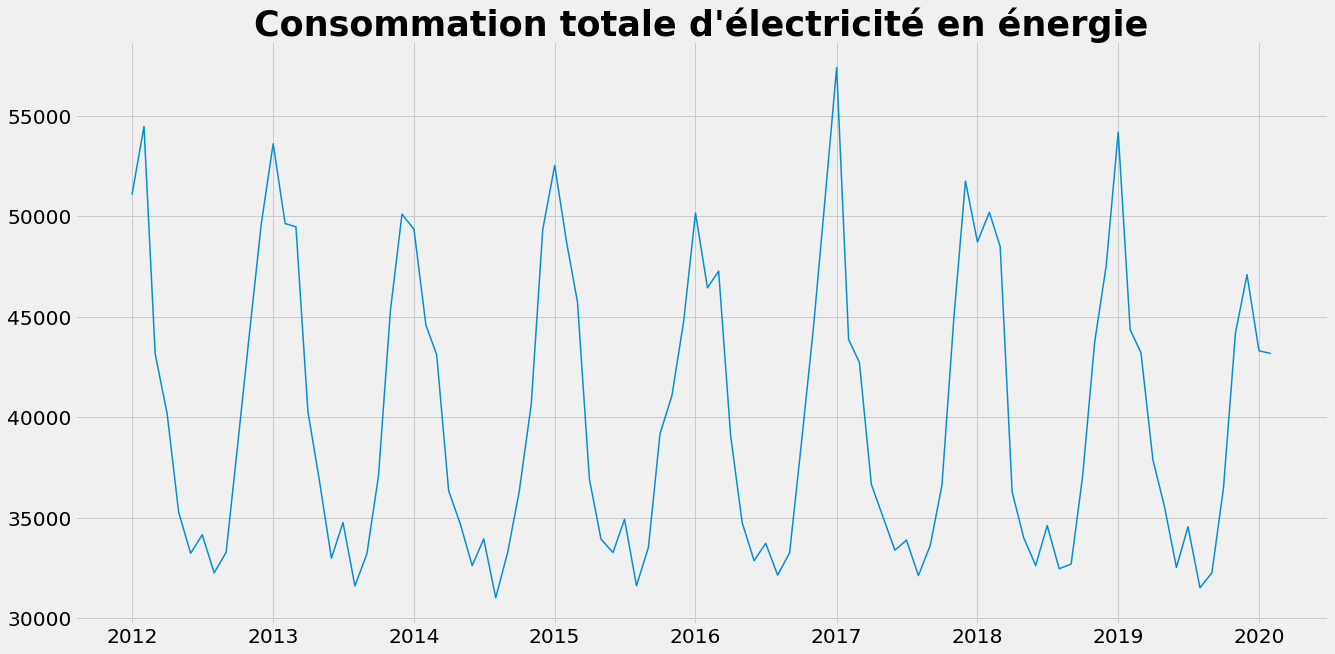

In [11]:
#Visualisation de la consommation totale d'électricité en énergie 
plt.plot(conso.consommation)
plt.title("Consommation totale d'électricité en énergie")
plt.savefig("p9_graphic/conso_elect.png")
plt.show()

Dans la série temporelle ci-dessus on peut identifier des cycles assez réguliers au cours du temps et de même
amplitude. Une correction des données de consommation mensuelles de l'effet température (dues au chauffage électrique) sera faite à l’aide de la régression linéaire. 

Il est donc nécessaire d'extraire les données propres au chauffage électrique sur la même période.

In [12]:
#Récapitulatif des consommations annuelles
conso.resample('Y').sum()

,consommation
mois,
2012-12-31,489517
2013-12-31,494842
2014-12-31,465150
2015-12-31,476050
2016-12-31,483219
2017-12-31,482008
2018-12-31,478431
2019-12-31,473739
2020-12-31,86473


L'agrégation des consommations mensuelles par année apporte également une vision rapide des dépenses énergétiques entre 2012 et 2020. 2020 étant une "année incomplète", et 2013 l'année la plus énergivore. Voyons l'impact du chauffage électrique.

#### Traitement du jeu de données exporté du site Cegibat, l'expertise efficacité énergétique de GRDF

In [13]:
#Chargement du dataset 'dju.xlsx'
data_dju = pd.read_excel('p9_data/dju.xlsx', header=None, skiprows=11)
data_dju.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,NaN,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
1,2019.0,404.9,268.3,233.1,168.5,117.9,14,0,0,0,0,0,0,1206.6
2,2018.0,303.4,432.6,314.3,119.7,55.9,8.1,0,3.3,34.3,122.4,282.5,325.9,2002.2
3,2017.0,467.9,278.4,206.1,182.6,75,9.4,1,6.8,62.6,99.4,282.6,369,2040.6
4,2016.0,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176,285.6,390.8,2207.3


L'année 2019 ne peut pas être prise en compte, on peut constater des valeurs nulles sur des mois hivernaux, il est judicieux d'exclure l'année de l'analyse.

In [14]:
#Suppression des deux premières lignes et dernière Series
data_dju.drop([0, 1], axis=0, inplace=True)
data_dju.drop([13], axis=1, inplace=True)

In [15]:
#La première Series est considérée comme index
data_dju[0] = data_dju[0].astype(int)
data_dju.set_index([0], inplace=True)

In [16]:
#Affichage des premières lignes du dataframe 
data_dju.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
2018,303.4,432.6,314.3,119.7,55.9,8.1,0,3.3,34.3,122.4,282.5,325.9
2017,467.9,278.4,206.1,182.6,75,9.4,1,6.8,62.6,99.4,282.6,369
2016,364.4,321.6,321.1,212.1,88.1,27.5,5.7,3.2,11.7,176,285.6,390.8
2015,392,365.7,275.5,141.1,91.5,15.8,6.9,6.1,71.9,176.9,195,248.1
2014,324.4,281.9,223.9,135.5,100.2,19.1,8.3,19.3,16,92.3,222.6,368.2


Il est nécessaire de transformer ces données de manière à obtenir une matrice temporelle.

In [17]:
#Transformation des données
dju = {'mois':[],'dju_chauffage':[]}

for year in data_dju.index.values:
    for month in data_dju.columns:
        dju['mois'].append(f"{year}-{month}")
        dju['dju_chauffage'].append(data_dju.loc[year,month])
        
dju = pd.DataFrame(dju)
dju['mois'] = pd.to_datetime(dju['mois'])

In [18]:
#Indexation des données selon les mois d'enregistrement
dju.set_index('mois', inplace=True)

In [19]:
#Aperçu des données mensuelles du chauffage électrique (dataframe "dju")
display(dju.head())
display(dju.shape)

,dju_chauffage
mois,
2018-01-01,303.4
2018-02-01,432.6
2018-03-01,314.3
2018-04-01,119.7
2018-05-01,55.9


(120, 1)

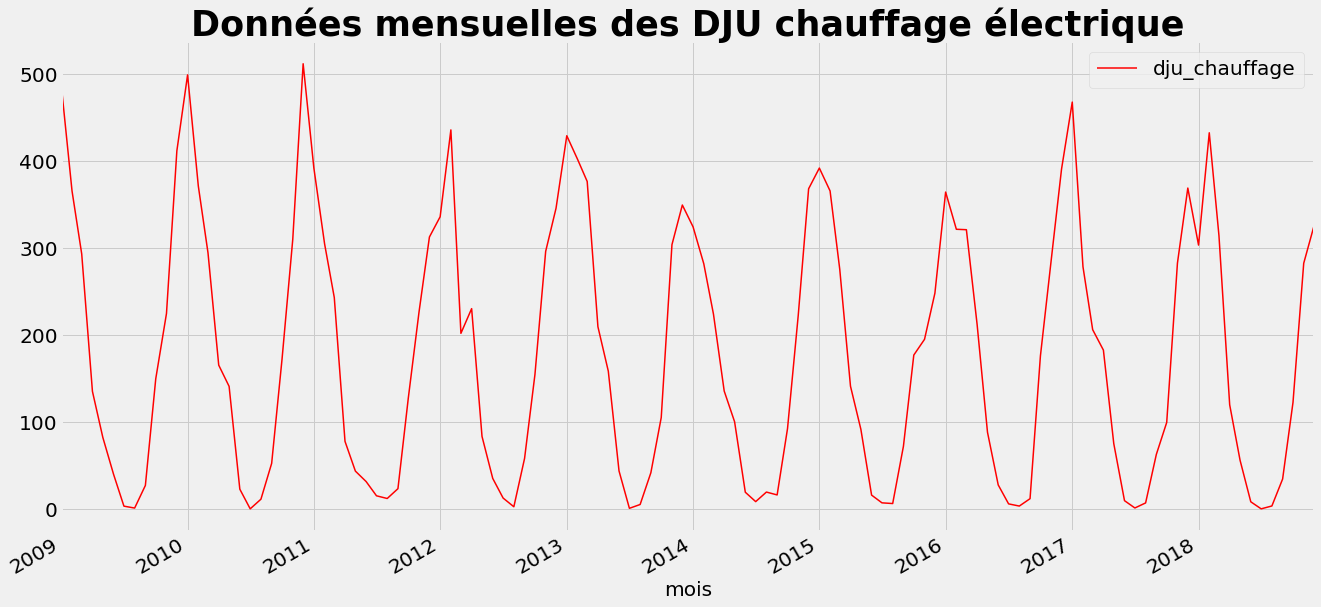

In [20]:
#Visualisation des données mensuelles des Degrés Jour Unifiés (DJU) chauffage électrique
dju.plot(color='r')
plt.title("Données mensuelles des DJU chauffage électrique")
plt.savefig("p9_graphic/dju_chauffage_elec.png")
plt.show()

Cette série temporelle prend naturellement en compte la saisonnalité liée aux conditions climatiques. Nos cycles mensuels évoluent donc en fonction de la température, et d'autres facteurs exogènes non pris en compte dans l'étude comme l’humidité, l'impact de la pollution, etc… Pour finir, les DJU sommés sur une période permettent de calculer les besoins de chauffage et de climatisation d’un bâtiment.

In [21]:
#Création d'un échantillon de travail par jointure des deux précédents dataframe
df = pd.merge(conso, dju, how='inner', on='mois')

In [22]:
#Visualisation de notre échantillon suite à la jointure
df

,consommation,dju_chauffage
mois,,
2012-01-01,51086,336.0
2012-02-01,54476,435.9
2012-03-01,43156,201.9
2012-04-01,40176,230.3
2012-05-01,35257,83.3
...,...,...
2018-08-01,32451,3.3
2018-09-01,32683,34.3
2018-10-01,37102,122.4


In [23]:
#Vérification rapide des éventuelles valeurs manquantes dans l'échantillon
df.isna().any()

consommation     False
dju_chauffage    False
dtype: bool

Les années 2019 et 2020 ne peuvent pas être validées pour l'analyse, des valeurs manquantes sont présentes sur ces deux années. Avec une jointure 'inner' l'exclusion est automatiquement réalisée.

In [24]:
#Statistiques descriptives de l'échantillon
df.describe().T

,count,mean,std,min,25%,50%,75%,max
consommation,84.0,40109.726190,7135.547804,31004.0,33696.75,37082.5,45914.250,57406.0
dju_chauffage,84.0,174.596429,143.731842,0.0,32.60,156.5,303.525,467.9


L'échantillon de travail étant désormais constitué, la prochaine étape consistera à corriger ces données de la consommation en électricité de l'effet température causé par le chauffage. <u>La régression linéaire sera utilisée</u>.

[Voir la suite du projet : Correction de l'effet de température et test statistique](https://github.com/nalron/project_electricity_forecasting/blob/french_version/p9_notebook02.ipynb)